In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sentence_transformers import SentenceTransformer, util

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

from my_util import get_chunks

/Users/nezumikozo/Documents/workspace/rag-redis-demo/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize topics

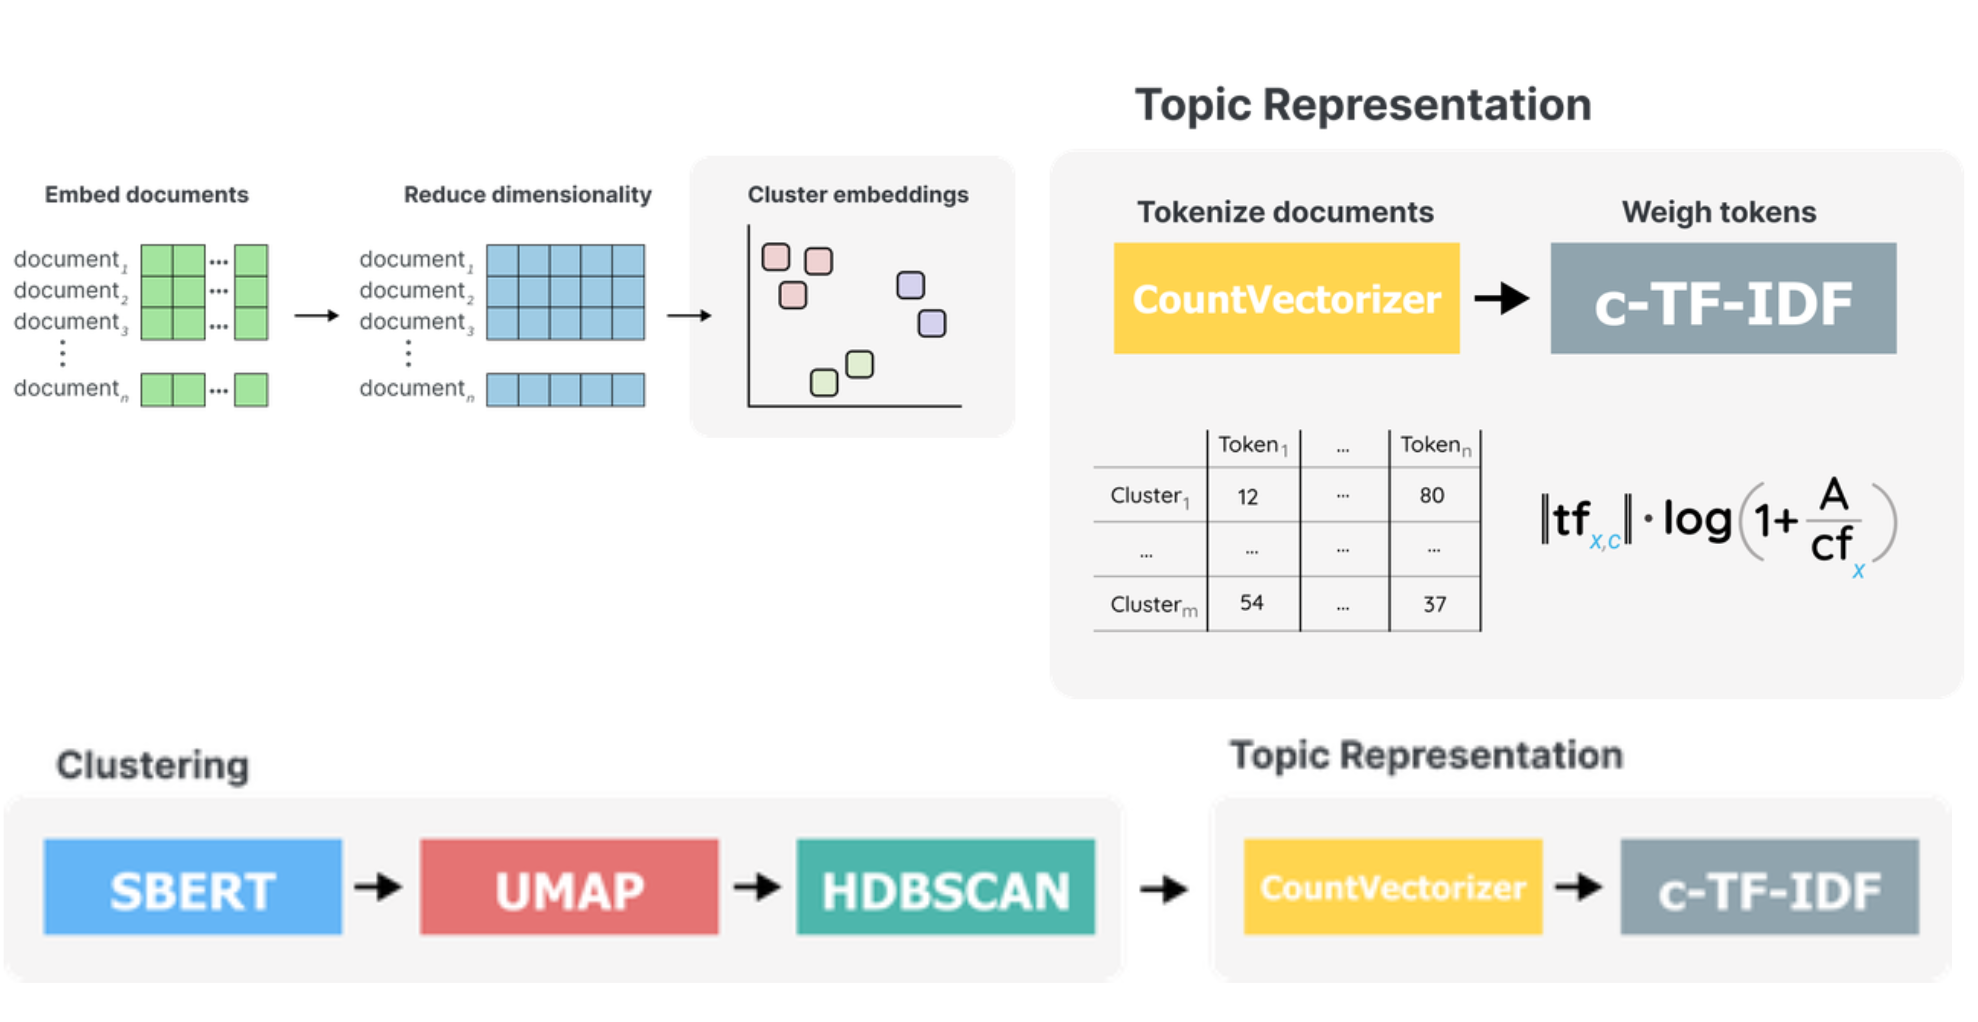

In [10]:
from IPython.display import Image
Image('pix/topics.png')

In [2]:
content, metadata = get_chunks(company_name="novo_nordisk")

In [3]:
def visualize_topics(docs, model_name, umap_init="spectral"):
    # Step 1 - Extract embeddings (blue block)
    embedding_model = SentenceTransformer(model_name, cache_folder="cache")

    # Step 2 - Reduce dimensionality (red block)
    # UMAP model is stochastic in nature which means that every time we run BERTopic, we will get different results.
    # We can prevent this by passing a `random_state` to the UMAP model.
    umap_model = UMAP(
        n_neighbors=15, 
        n_components=10, 
        min_dist=0.0, 
        metric='cosine', 
        random_state=42, 
        init=umap_init
    )

    # Step 3 - Cluster reduced embeddings (green block)
    hdbscan_model = HDBSCAN(
        min_cluster_size=15, 
        metric='euclidean', 
        cluster_selection_method='eom',
        prediction_data=True
    )

    # Step 4 - Tokenize topics (yellow block)
    vectorizer_model = CountVectorizer(stop_words="english")

    # Step 5 - Create topic representation (grey block)
    ctfidf_model = ClassTfidfTransformer()

    # Step 6 - (Optional) Fine-tune topic representations with
    # a `bertopic.representation` model (purple block)
    representation_model = KeyBERTInspired()

    # Combine the steps and build our own topic model
    topic_model = BERTopic(
        embedding_model=embedding_model,  # Step 1 - Extract embeddings
        umap_model=umap_model,  # Step 2 - Reduce dimensionality
        hdbscan_model=hdbscan_model,  # Step 3 - Cluster reduced embeddings
        vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
        ctfidf_model=ctfidf_model,  # Step 5 - Extract topic words
        representation_model=representation_model  # Step 6 - Fine-tune topics
    )

    topics, probs = topic_model.fit_transform(docs)

    # Visualize topics
    fig = topic_model.visualize_topics()
    fig.write_html("pix/topics_visual.html")
    
    return topic_model, topics

In [4]:
# If the chunks are less than 2k, the default umap's init="spectral" will fail due to being sparse...
topic_model, topics = visualize_topics(
    docs=content*3, 
    model_name="sentence-transformers/msmarco-distilbert-base-tas-b", 
    umap_init="random",
)

In [5]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,214,-1_dkk_assets_million_novo_nordisk,"[dkk, assets, million, novo_nordisk, nordisk, ...",[Company: novo_nordisk. 4.9 Financial assets a...
1,0,75,0_novo_nordisk_novonordisk_novo_nordisk,"[novo_nordisk, novonordisk, novo, nordisk, rem...",[Company: novo_nordisk. Novo Nordisk has prepa...
2,1,45,1_novo_nordisk_dkk_million_securities,"[novo_nordisk, dkk, million, securities, asset...",[Company: novo_nordisk. Cash flow statement\n\...
3,2,39,2_novo_nordisk_nordisk_audit_novo,"[novo_nordisk, nordisk, audit, novo, revisions...",[Company: novo_nordisk. Independent Auditor’s ...
4,3,36,3_novo_nordisk_novo_nordisk_ceo,"[novo_nordisk, novo, nordisk, ceo, governance,...",[Company: novo_nordisk. Annual Report 2022\n\n...
5,4,36,4_novo_nordisk_nordisk_novo_hedge,"[novo_nordisk, nordisk, novo, hedge, hedged, s...","[Company: novo_nordisk. 938\n\n49\n\n1,789\n\n..."
6,5,36,5_novo_nordisk_nordisk_diversity_gender,"[novo_nordisk, nordisk, diversity, gender, nov...",[Company: novo_nordisk. representation was the...
7,6,36,6_novo_nordisk_esg_nordisk_novo,"[novo_nordisk, esg, nordisk, novo, emissions, ...",[Company: novo_nordisk. Energy consumption for...
8,7,33,7_novo_nordisk_novo_nordisk_shareholders,"[novo_nordisk, novo, nordisk, shareholders, sh...",[Company: novo_nordisk. 4 May 2023 Financial s...
9,8,30,8_dkk_denmark_danish_novo_nordisk,"[dkk, denmark, danish, novo_nordisk, nordisk, ...",[Company: novo_nordisk. Other adjustments (net...


In [6]:
topics[251]

6

In [7]:
topic_model.get_topic(6)

[('novo_nordisk', 0.77169406),
 ('esg', 0.7386734),
 ('nordisk', 0.7339364),
 ('novo', 0.731315),
 ('emissions', 0.72266823),
 ('tonnes', 0.7201028),
 ('000', 0.70370114),
 ('consumption', 0.69833755),
 ('renewable', 0.6969034),
 ('gj', 0.69258547)]

In [8]:
topic_model.find_topics(f"scope 1 emissions")

([-1, 6, 3, 5, 0], [0.7566165, 0.7504076, 0.74483055, 0.7252919, 0.7213981])

In [9]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(content[251], calculate_tokens=True)
df = topic_model.visualize_approximate_distribution(content[251], topic_token_distr[0])

with open('pix/topic_distr.html', 'w') as f:
    df.to_html(f)